On pourrait la croire tombée en désuétude avec l'envol de bibliothèques [comme D3js](https://d3js.org) ou de logiciels [comme tableau](https://www.tableau.com/fr-fr/trial/tableau-software?utm_campaign_id=2017049&utm_campaign=Prospecting-CORE-ALL-ALL-ALL-ALL&utm_medium=Paid+Search&utm_source=Google+Search&utm_language=FR&utm_country=FRAN&kw=tableau%20software&adgroup=CTX-Brand-Tableau+Software-FR-E&adused=329973702622&matchtype=e&placement=&gclid=Cj0KCQiAoab_BRCxARIsANMx4S56sdgvyQ_GySi_Shr-IyrvPlc-LIiqZGB--8ueYDbs4eIVN0mWIAgaAk6oEALw_wcB&gclsrc=aw.ds). **L'infographie statique a pourtant encore de beaux jours devant elle**, en particulier sur les réseaux sociaux.

Le langage Python a de réels atouts en la matière. Synthétique, puissant, précis. Ce carnet regroupe, en guise d'illustrations, trois tutoriels aboutissant à **plusieurs visualisations simples** (mais efficaces) de la mortalité COVID-19 à différentes échelles.

![Trois tutos pour le prix d'un](tuto_matplotlib.png "Title")

La complémentarité entre les modules [pandas](https://pandas.pydata.org/) côté stats et [matplotlib](https://matplotlib.org/) côté visu sera bien sûre au coeur de la démarche. En se plaçant du point de vue de journaliste, on cherchera aussi **à éditorialiser** (au moins un peu) **les infographies**.

## Une visualisation générale pour s'exercer

On démarre avec l'import des modules pandas et matplotlib :

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

Il est temps de digérer un [csv fourni par Santé Publique France](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/), en transformant ce dernier en DataFrame. La DF, c'est un des formats privilégiés dans pandas :

In [2]:
DF = pd.read_csv("donnees-hospitalieres-covid19-2020-12-29-19h03.csv", sep=";")

DF.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


On ne va retenir que les cellules où "sexe" a une valeur de 0 (l'addition entre les décès de femmes et ceux des hommes). Pour ce faire, et en hommage à l'actualité, le plus simple est **d'utiliser un masque** : 

* on pose **une condition en variable**
* on **l'utilise ensuite pour màj la DF**

In [3]:
condi_sexe = DF["sexe"] == 0
DF = DF[condi_sexe]

DF.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
3,02,0,2020-03-18,41,10,18,11
6,03,0,2020-03-18,4,0,1,0
9,04,0,2020-03-18,3,1,2,0
12,05,0,2020-03-18,8,1,9,0


On vérifie qu'il n'y a bien qu'une seul valeur 0 dans la colonne "sexe" :

In [4]:
print(DF["sexe"].unique())

[0]


On crée une nouvelle DataFrame en zappant les colonnes hosp, rea et rad :

In [5]:
DF_deces = DF[["dep","jour","dc"]]

DF_deces.head()

,dep,jour,dc
0,01,2020-03-18,0
3,02,2020-03-18,11
6,03,2020-03-18,0
9,04,2020-03-18,0
12,05,2020-03-18,0


A présent, on va additionner les chiffres départementaux par jour, pour avoir le nombre de décès totaux sur l'ensemble du territoire français. Cela se traduit par :

In [6]:
DF_deces = DF_deces.groupby("jour").sum().reset_index()

DF_deces.head()

,jour,dc
0,2020-03-18,218
1,2020-03-19,327
2,2020-03-20,450
3,2020-03-21,525
4,2020-03-22,632


Ces données sont **cumulatives** : si l'on veut les données quotidiennes il faut à partir de la deuxième ligne **soustraire à la cellule "dc" la valeur de la ligne précédente**.

En langage pandas, cela donne, en créant une nouvelle Serie "dcq" :

In [7]:
DF_deces['dcq'] = DF_deces['dc'].diff().fillna(DF_deces['dc']).astype(int)

DF_deces.head()

,jour,dc,dcq
0,2020-03-18,218,218
1,2020-03-19,327,109
2,2020-03-20,450,123
3,2020-03-21,525,75
4,2020-03-22,632,107


Plus qu'à oublier la Serie "dc", devenue inutile :

In [8]:
DF_deces = DF_deces[["jour","dcq"]]

DF_deces.head()

,jour,dcq
0,2020-03-18,218
1,2020-03-19,109
2,2020-03-20,123
3,2020-03-21,75
4,2020-03-22,107


Ces données quotidiennes sont sujettes à des fluctuations, notamment les week-ends, ce qui rend la lecture des chiffres pénible. 

Une convention est **de plaquer une moyenne glissante par-dessus**. On va partir sur sept jours glissants dans une nouvelle Serie, comme ceci :

In [9]:
DF_deces["dcm"] = DF_deces["dcq"].rolling(7, min_periods=1, center = False).mean()

#ne soyons pas avares, et convertissons aussi les dates en chaînes de cara en dates compréhensibles par pandas
DF_deces["jour"] = pd.to_datetime(DF_deces["jour"])

DF_deces.head()

,jour,dcq,dcm
0,2020-03-18,218,218.00
1,2020-03-19,109,163.50
2,2020-03-20,123,150.00
3,2020-03-21,75,131.25
4,2020-03-22,107,126.40


Maintenant arrive le premier gros morceau, avec une première visualisation **des décès quotidiens et de leur moyenne glissante**.

La plupart des options décrites ci-après sont assez intuitives pour que je m'épargne de les commenter ligne par ligne. J'insisterai quand même sur :

* **le formatage de l'axe des abscisses**, avec définition de dates et marques toutes les semaines pour ne pas surcharger sa lecture
* l'option **fill_between()** qui permet de colorier les dates couvertes par les confinements.

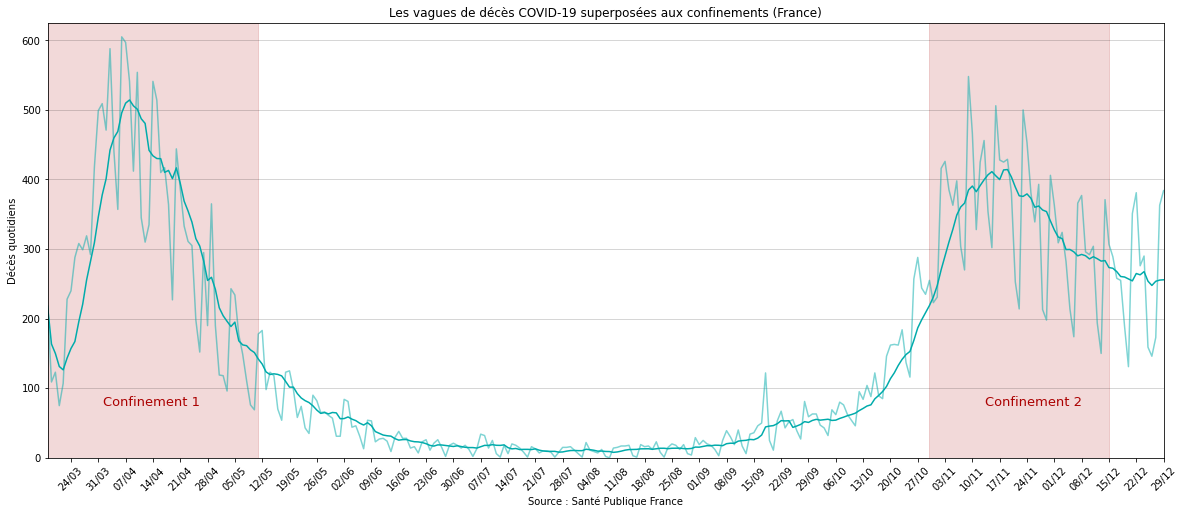

In [10]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens", title="Les vagues de décès COVID-19 superposées aux confinements (France)")
ax.set_xlim(min(DF_deces["jour"]), max(DF_deces["jour"]))
ax.set_ylim(0, max(DF_deces["dcq"])+20)
date_form = DateFormatter("%d/%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_tick_params(rotation=45)
ax.fill_between(DF_deces["jour"], 0, max(DF_deces["dcq"]+20), where=((DF_deces["jour"]<"2020-05-12") | (DF_deces["jour"]>"2020-10-29") & (DF_deces["jour"]<"2020-12-16")), color='#ab0000', alpha=.15) 
ax.text(0.05, 0.12, 'Confinement 1',  transform=ax.transAxes, color="#ab0000", fontsize=13)
ax.text(0.84, 0.12, 'Confinement 2',  transform=ax.transAxes, color="#ab0000", fontsize=13)
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.plot(DF_deces["jour"],DF_deces["dcq"], color="#00abab", alpha=.5)
ax.plot(DF_deces["jour"],DF_deces["dcm"], color="#00abab")
plt.savefig('covid_dc_lin.png', dpi=200)
plt.show()

Un tableau général est là, reste plus qu'à le compléter.

## Une analyse plus poussée à base de superposition

Après cette vue d'ensemble, une piste d'analyse pourrait être d'isoler les décès survenus lors des deux confinements et **de comparer certains indices** (médiane et somme, par exemple).

La manière simple de sélectionner les tranches d'une DF avec pandas consiste toujours : 

* à définir **une condition en variable**
* et à utiliser cette dernière comme **tamis d'une nouvelle DF**

In [11]:
DF_conf1 = DF_deces[["jour","dcq"]]
condi_confinement1 = DF_deces["jour"]<"2020-05-12"

DF_conf1 = DF_conf1[condi_confinement1]

DF_conf1.tail()

,jour,dcq
50,2020-05-07,149
51,2020-05-08,111
52,2020-05-09,76
53,2020-05-10,69
54,2020-05-11,178


On peut faire de même avec le dernier confinement en date :

In [12]:
DF_conf2 = DF_deces[["jour","dcq"]]
condi_confinement2 = (DF_deces["jour"]>"2020-10-29") & (DF_deces["jour"]<"2020-12-16")

DF_conf2 = DF_conf2[condi_confinement2].reset_index()
DF_conf2 = DF_conf2[["jour","dcq"]]

DF_conf2.tail()

,jour,dcq
42,2020-12-11,304
43,2020-12-12,194
44,2020-12-13,150
45,2020-12-14,371
46,2020-12-15,307


La [fonction describe()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) de pandas va dresser des cartes générales de ces DF :

In [13]:
DF_conf1.describe()

,dcq
count,55.000000
mean,305.472727
std,152.691392
min,69.000000
25%,184.000000
50%,305.000000
75%,414.500000
max,605.000000


In [14]:
DF_conf2.describe()

,dcq
count,47.000000
mean,340.255319
std,94.908759
min,150.000000
25%,276.000000
50%,354.000000
75%,411.000000
max,548.000000


Quelques observations globales :

* malgré une durée supérieure (55 jours contre 47), la médiane de décès quotidiens pendant le premier confinement s'établit à 305, contre 354 pour le deuxième
* le premier confinement a connu un pic supérieur au second (605 décès quotidiens contre 548) mais le dernier quartile est équivalent entre les deux (414 contre 411) et surtout le premier quartile du second confinement est bien supérieur (184 décès quotidiens au premier, 276 au second)
* la déviation standard plus réduite pour le second confinement confirme des valeurs plus tassées que lors du premier

Tout cela est bel et bon, mais est-ce que ce ne serait pas mieux de le visualiser ? Sans doute, et une première possibilité est de faire passer la moyenne glissante **à l'échelle logarithmique**.

Son avantage principal est de **[transformer une courbe exponentielle en ligne diagonale](https://images.math.cnrs.fr/Epidemie-et-logarithme.html) (à peu près) droite**. Magie de matplotlib, le code précédent va se recycler en deux coups de cuillère à pot :

<ipython-input-15-d03560b82e10>:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, 1000)


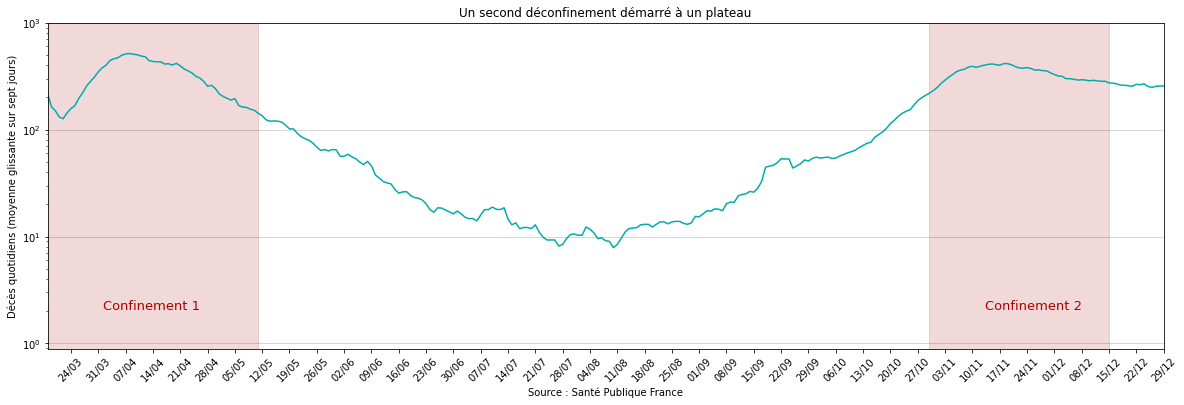

In [15]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens (moyenne glissante sur sept jours)", title="Un second déconfinement démarré à un plateau")
ax.set_xlim(min(DF_deces["jour"]), max(DF_deces["jour"]))
ax.set_yscale('log')
ax.set_ylim(0, 1000)
date_form = DateFormatter("%d/%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_tick_params(rotation=45)
ax.fill_between(DF_deces["jour"], 0, 1000, where=((DF_deces["jour"]<"2020-05-12") | (DF_deces["jour"]>"2020-10-29") & (DF_deces["jour"]<"2020-12-16")), color='#ab0000', alpha=.15) 
ax.text(0.05, 0.12, 'Confinement 1',  transform=ax.transAxes, color="#ab0000", fontsize=13)
ax.text(0.84, 0.12, 'Confinement 2',  transform=ax.transAxes, color="#ab0000", fontsize=13)
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.plot(DF_deces["jour"],DF_deces["dcm"], color="#00abab")
plt.show()

Ce graphique peut inspirer au moins deux remarques :

* l'enclenchement de l'exponentielle, ou un départ crédible de la droite qui mène au second confinement, peut se lire **vers la seconde moitié d'août**. Absolument indétectable sur une échelle linéaire classique
* le **plateau de décès** en fin de second confinement **est accentué**

Un autre angle d'attaque consisterait à superposer les deux moyennes glissantes aux mêmes délais de confinement (de J+2 à une certaine durée).

Hygiène de programmation oblige, on va coder une fonction qui va :

* considérer une DF à manipuler, une date de fin d'une première période, une date de début d'une seconde, et une statistique
* créer **deux DF transitoires**, l'une pour la première période, l'autre pour la seconde
* créer dans chacune d'elle **une Serie** (ou colonne) **"délai"** qui démarrera de 2 jusqu'à la fin de la période. Pour rappel les stats de SPF démarrent le 18 mars 2020, soit **le deuxième jour du premier confinement**
* joindre les deux DF à partir de leur Serie commune "delai", en veillant à se calquer sur la plus courte des deux
* retourner le résultat de cette jointure

En considérant que la DF à tailler a toujours une série "jour", cela donne :

In [16]:
def compa_confi(DF_a_tailler,d_fin_p1,d_debut_p2,colonne):
    # on commence petit, avec les noms de colonnes qui permettront de différencier la période
    n_nom1 = colonne+"1"
    n_nom2 = colonne+"2"
    
    DF_transit = DF_a_tailler[["jour", colonne]]
    
    # les conditions, déclarées en variables
    condi_p1 = DF_a_tailler["jour"]< d_fin_p1
    condi_p2 = DF_a_tailler["jour"]> d_debut_p2
    
    # une première DF transitoire, avec aussi la création de la Serie "delai"
    DF_p1 = DF_transit[condi_p1]
    DF_p1["delai"] = DF_p1.index+2

    # même chose pour la deuxième
    DF_p2 = DF_transit[condi_p2].reset_index()
    DF_p2["delai"] = DF_p2.index+2
    
    # on renomme la colonne par son équivalent +1, pour éviter de confondre
    DF_p1.rename(columns={colonne: n_nom1}, inplace=True)
    DF_p1 = DF_p1[["delai",n_nom1]]
    
    # pareil ici
    DF_p2.rename(columns={colonne: n_nom2}, inplace=True)
    DF_p2 = DF_p2[["delai",n_nom2]]

    # une petite condition pour faire la jointure sur la DF la plus petite des deux
    if len(DF_p2)<len(DF_p1):
        DF_finale = pd.merge(DF_p2, DF_p1, how="left", on = "delai")
    else:
        DF_finale = pd.merge(DF_p1, DF_p2, how="left", on = "delai")
    print(DF_finale.tail())
    
    return DF_finale

Et si on testait ça en comparant le décès quotidiens des confinements ? 

Comme disait le regretté Maradona : "une ligne, et c'est parti" !

In [17]:
DF_dcq12 = compa_confi(DF_deces, "2020-06-01","2020-10-30","dcq")

    delai  dcq2  dcq1
55     57   159   183
56     58   146    98
57     59   173   123
58     60   363   118
59     61   384    70


<ipython-input-16-a2286234374f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_p1["delai"] = DF_p1.index+2
c:\users\raphael\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


On repart sur un recyclage de code, où l'accent sera mis sur **le différentiel de morts entre les deux confinements**. Autrement dit, sur quels jours il y a plus de morts pour l'un, ou pour l'autre.

Dans ce cas précis, vous remarquerez la puissance de fill_between, invoqué **pour colorer les différentiels** :

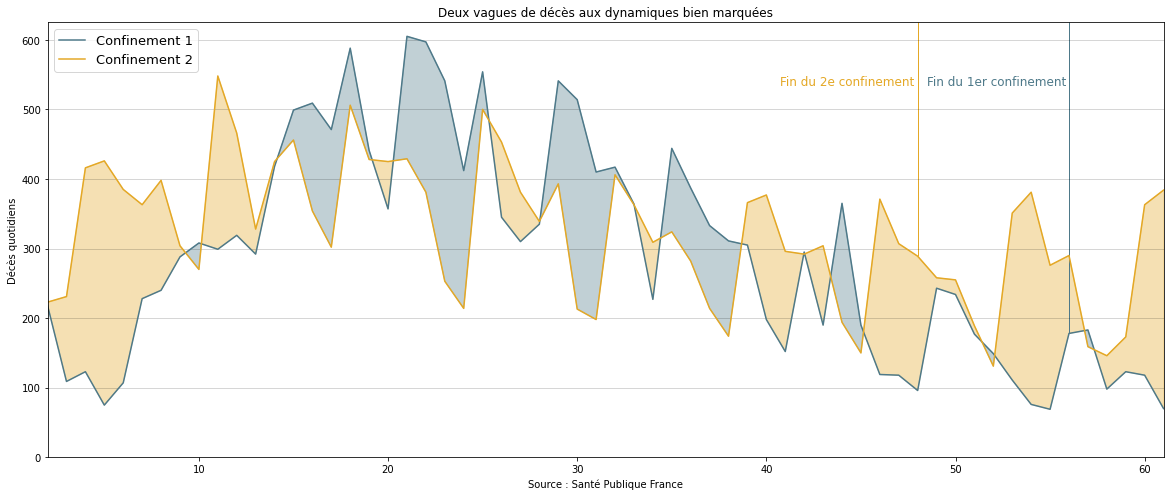

In [18]:
f_c1 = 56
f_c2 = 48

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens", title="Deux vagues de décès aux dynamiques bien marquées")
ax.set_xlim(min(DF_dcq12["delai"]), max(DF_dcq12["delai"]))
ax.set_ylim(0, max(DF_dcq12["dcq1"])+20)
ax.fill_between(DF_dcq12["delai"], DF_dcq12["dcq1"], DF_dcq12["dcq2"], where=DF_dcq12["dcq2"]>=DF_dcq12["dcq1"], color="#E4A826", alpha=.35, interpolate=True)
ax.fill_between(DF_dcq12["delai"], DF_dcq12["dcq2"], DF_dcq12["dcq1"], where=DF_dcq12["dcq2"]<DF_dcq12["dcq1"], color="#4E7989", alpha=.35, interpolate=True)
ax.fill_between(DF_dcq12["delai"], DF_dcq12["dcq2"], max(DF_dcq12["dcq1"])+20, where=DF_dcq12["delai"]==f_c2, color="#E4A826", alpha=1)
ax.text(f_c2-7.3, 535, 'Fin du 2e confinement',  color="#E4A826", fontsize=12)
ax.fill_between(DF_dcq12["delai"], DF_dcq12["dcq1"], max(DF_dcq12["dcq1"])+20, where=DF_dcq12["delai"]==f_c1, color="#4E7989", alpha=1)
ax.text(f_c1-7.5, 535, 'Fin du 1er confinement', color="#4E7989", fontsize=12)
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.plot(DF_dcq12["delai"],DF_dcq12["dcq1"], color="#4E7989" , label = "Confinement 1")
ax.plot(DF_dcq12["delai"],DF_dcq12["dcq2"], color="#E4A826", label = "Confinement 2")
ax.legend(loc='upper left', fontsize=13)
plt.show()

Ce n'est peut-être pas la formule la plus lisible, il vaudrait peut-être mieux **colorer les moyennes glissantes** et garder en repères d'arrière-plan les chiffres de mortalité bruts.

Quelle guigne ! Va-t-on devoir se fader le codage d'une nouvelle fonction ? Pas forcément, par exemple avec :

In [19]:
DF_dcm12 = compa_confi(DF_deces, "2020-06-01","2020-10-30","dcm")

    delai        dcm2        dcm1
55     57  253.857143  134.714286
56     58  247.714286  123.428571
57     59  253.714286  119.714286
58     60  255.428571  120.714286
59     61  255.857143  119.857143


<ipython-input-16-a2286234374f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_p1["delai"] = DF_p1.index+2
c:\users\raphael\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Et on visualise :

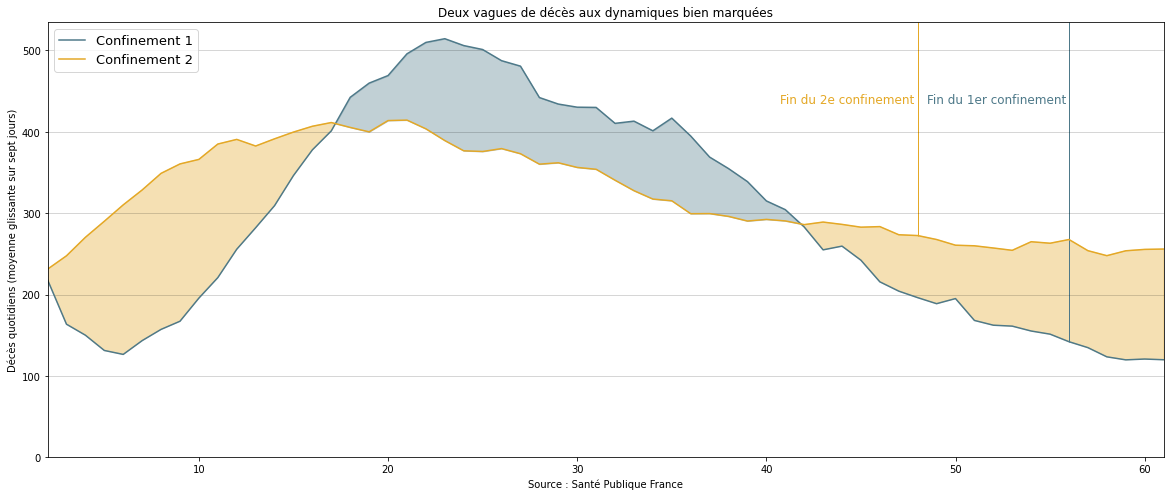

In [20]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens (moyenne glissante sur sept jours)", title="Deux vagues de décès aux dynamiques bien marquées")
ax.set_xlim(min(DF_dcm12["delai"]), max(DF_dcm12["delai"]))
ax.set_ylim(0, max(DF_dcm12["dcm1"])+20)
ax.fill_between(DF_dcm12["delai"], DF_dcm12["dcm1"], DF_dcm12["dcm2"], where=DF_dcm12["dcm2"]>=DF_dcm12["dcm1"], color="#E4A826", alpha=.35, interpolate=True)
ax.fill_between(DF_dcm12["delai"], DF_dcm12["dcm2"], DF_dcm12["dcm1"], where=DF_dcm12["dcm2"]<DF_dcm12["dcm1"], color="#4E7989", alpha=.35, interpolate=True)
ax.fill_between(DF_dcm12["delai"], DF_dcm12["dcm2"], max(DF_dcm12["dcm1"])+20, where=DF_dcm12["delai"]==f_c2, color="#E4A826")
ax.text(f_c2-7.3, 435, 'Fin du 2e confinement',  color="#E4A826", fontsize=12)
ax.fill_between(DF_dcm12["delai"], DF_dcm12["dcm1"], max(DF_dcm12["dcm1"])+20, where=DF_dcm12["delai"]==f_c1, color="#4E7989", alpha=1)
ax.text(f_c1-7.5, 435, 'Fin du 1er confinement',  color="#4E7989", fontsize=12)
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.plot(DF_dcm12["delai"],DF_dcm12["dcm1"], color="#4E7989", label = "Confinement 1")
ax.plot(DF_dcm12["delai"],DF_dcm12["dcm2"], color="#E4A826", label = "Confinement 2")
ax.legend(loc='upper left', fontsize=13)
plt.show()

L'échelle des abscisses étant la même, on peut parfaitement **placer des éléments de deux DF distinctes sur une même visualisation**.

Démonstration ? Démonstration :

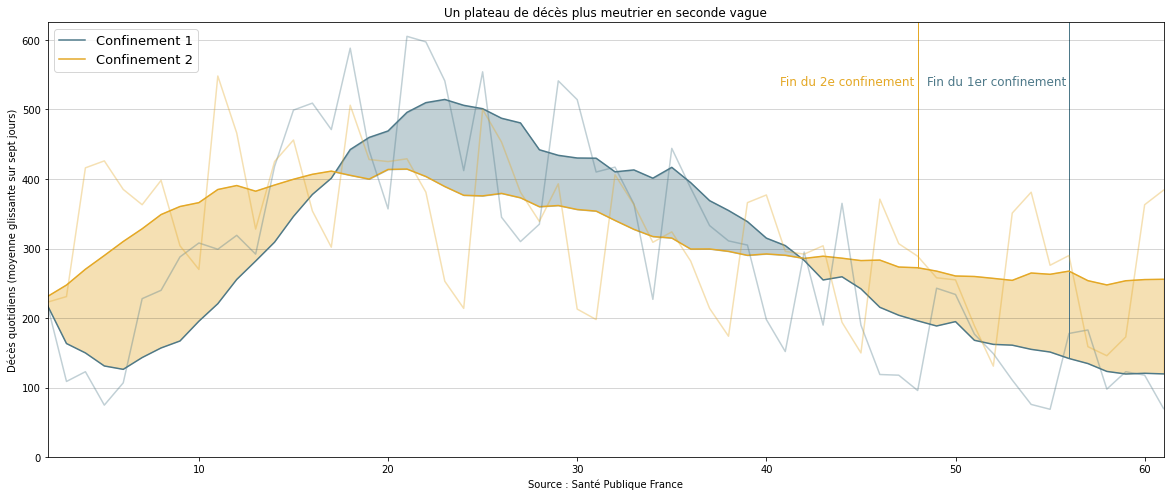

In [21]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens (moyenne glissante sur sept jours)", title="Un plateau de décès plus meutrier en seconde vague")
ax.set_xlim(min(DF_dcm12["delai"]), max(DF_dcm12["delai"]))
ax.set_ylim(0, max(DF_dcq12["dcq1"])+20)
ax.fill_between(DF_dcm12["delai"], DF_dcm12["dcm1"], DF_dcm12["dcm2"], where=DF_dcm12["dcm2"]>=DF_dcm12["dcm1"], color="#E4A826", alpha=.35, interpolate=True)
ax.fill_between(DF_dcm12["delai"], DF_dcm12["dcm2"], DF_dcm12["dcm1"], where=DF_dcm12["dcm2"]<DF_dcm12["dcm1"], color="#4E7989", alpha=.35, interpolate=True)
ax.fill_between(DF_dcq12["delai"], DF_dcm12["dcm2"], max(DF_dcq12["dcq1"])+20, where=DF_dcq12["delai"]==f_c2, color="#E4A826", alpha=1)
ax.text(f_c2-7.3, 535, 'Fin du 2e confinement', color="#E4A826", fontsize=12)
ax.fill_between(DF_dcq12["delai"], DF_dcm12["dcm1"], max(DF_dcq12["dcq1"])+20, where=DF_dcq12["delai"]==f_c1, color="#4E7989", alpha=1)
ax.text(f_c1-7.5, 535, 'Fin du 1er confinement',  color="#4E7989", fontsize=12)
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.plot(DF_dcm12["delai"],DF_dcm12["dcm1"], color="#4E7989", label = "Confinement 1")
ax.plot(DF_dcm12["delai"],DF_dcm12["dcm2"], color="#E4A826", label = "Confinement 2")
ax.plot(DF_dcq12["delai"],DF_dcq12["dcq1"], color="#4E7989", alpha =.35)
ax.plot(DF_dcq12["delai"],DF_dcq12["dcq2"], color="#E4A826", alpha =.35)
ax.legend(loc='upper left', fontsize=13)
plt.savefig('diff_dc_total.png', dpi=200)
plt.show()

On peut aussi, en complément de cette figure, de glâner quelques stats, ce qui a toujours le mérite de **contextualiser** (au moins un peu) **les infographies**.

In [22]:
DF_dcq12["dcq2"].sum()

19382

In [23]:
DF_dcq12["dcq1"].sum()

17393

Soit, sur la même durée, presque 2 000 morts de plus dans les hôpitaux lors de la seconde vague...

## Une segmentation à l'échelle régionale

Cela a été souligné au début de l'épidémie de covid-19 en France : la première vague **a été très localisée**, notamment portée par les chiffres du Grand-Est (Alsace en tête) et d'Île-de-France (Paris en tête).

Peut-on vérifier cela par une visualisation ? Oui, avec comme toujours **le souci du code bien factorisé**. Cela évite de s'éparpiller, de copier/coller des bouts de code dispersés, de répéter des choses rébarbatives, de déclencher des erreurs difficiles à détricotr... Bref, que-des-a-van-tages !

On part donc sur une fonction qui va **additionner les chiffres des départements de chaque région scrutée**

On va créer en préambule une variable rassemblant des infos géographiques. On part sur **un dictionnaire Python**, avec :

* une région en clé
* un tableau de départements en résultat

In [24]:
reg_dep_FR = {"Auvergne-Rhône-Alpes": ["01","03","07","15","26","38","42","43","63","69","73","74"], 
              "Bourgogne-Franche-Comté" : ["21","25","39","58","70","71","89","90"],
              "Bretagne" : ["22","29","35","56"],
              "Centre-Val-de-Loire" : ["18","28","36","37","41","45"],
              "Corse" : ["2A","2B"],
              "Grand-Est" : ["08","10","51","52","54","55","57","67","68","88"],
              "Hauts-de-France" : ["02","59","60","62","80"],
              "Île-de-France" : ["75","77","78","91","92","93","94","95"],
              "Normandie" : ["14","27","50","61","76"],
              "Nouvelle-Aquitaine" : ["16","17","19","23","24","33","40","47","64","79","86","87"],
              "Occitanie" : ["09","11","12","30","31","32","34","46","48","65","66","81","82"],
              "Pays-de-la-Loire" : ["44","49","53","72","85"],
              "Provence-Alpes-Côte d'Azur" : ["04","05","06","13","83","84"]}

On peut maintenant passer à la fonction :

In [25]:
def dc_region(DF,tableau_regions):
    # on commence par ne retenir que le sexe 0, addition des femmes et des hommes
    condi_sexe = DF["sexe"] == 0
    DF = DF[condi_sexe]
    DF = DF[["dep","jour","dc"]]
    
    tampon=[]
    for region in tableau_regions:
        if region in reg_dep_FR:
            # chaque département trouvé en le dico de référence a sa région renseignée dans une nouvelle Serie
            r = DF.assign(region=DF["dep"].map(dict.fromkeys(reg_dep_FR[region], region)))
            # ensuite, on groupe chaque région en additionnant ses valeurs et on efface ce qui n'a pas preneur
            r = r.dropna().groupby(['region', 'jour'])['dc'].sum().reset_index()
            #les chiffres sont cumulatifs, donc on crée une Serie quotidienne pour parer à ça
            r["dcq"] = r['dc'].diff().fillna(r['dc']).astype(int)
            # et on ne retient qu'elle à l'arrivée
            r = r[["region","jour","dcq"]]
            tampon.append(r)
    # on rassemble dans une même DF les différentes régions        
    DF_transit = pd.concat(tampon, ignore_index=True)
    # on passe en mode tableau croisé dynamique pour que chaque région devienne une Serie à part entière
    DF_transit = pd.pivot_table(DF_transit, values='dcq', index=['jour'],columns=['region'])
    # on transforme ce tcd en nouvelle DF
    DF_finale = pd.DataFrame(DF_transit.to_records())
    # conversion des jours en bonne date...
    DF_finale["jour"] = pd.to_datetime(DF_finale["jour"])
    # et on sert !
    return DF_finale

On peut tester de suite cette fonction en conditions réelles, par exemple sur les régions de France métropolitaine :

In [26]:
liste_regions = list(reg_dep_FR.keys())

DF_tregions = dc_region(DF,liste_regions)

DF_tregions.head()

,jour,Auvergne-Rhône-Alpes,Bourgogne-Franche-Comté,Bretagne,Centre-Val-de-Loire,Corse,Grand-Est,Hauts-de-France,Normandie,Nouvelle-Aquitaine,Occitanie,Pays-de-la-Loire,Provence-Alpes-Côte d'Azur,Île-de-France
0,2020-03-18,7,6,7,1,0,120,21,3,2,6,1,7,36
1,2020-03-19,15,8,2,0,1,28,19,2,1,11,0,2,20
2,2020-03-20,11,8,3,1,2,35,11,2,1,4,0,2,43
3,2020-03-21,5,5,3,0,1,26,5,-1,1,3,2,2,23
4,2020-03-22,9,13,2,1,2,43,11,2,3,1,1,1,18


Quelques observations à ce stade :

* il y a une aberration, avec une valeur négative pour la Normandie. **Ce -1 n'est pas une erreur de calcul**, il y a bien un décès de moins 21 mars en comparaison de la veille. Cela peut être dû à une erreur de saisie
* c'est évident, mais la répartition des décès hospitalier **n'est pas homogène entre les différentes régions**
* il se peut donc que, pour des questions de lisibilité, **on vire quelques régions marginales**. Ce serait par exemple le cas des Pays-de-la-Loire, de la Corse et du Centre-Val-de-Loire
* mais avant, de trancher, **autant visualiser !**

On va partir sur **des histogrammes empilés**, ou stacked bars en bon anglais. Voici ce qu'on peut coder à partir d'exemples trouvés sur le Net :

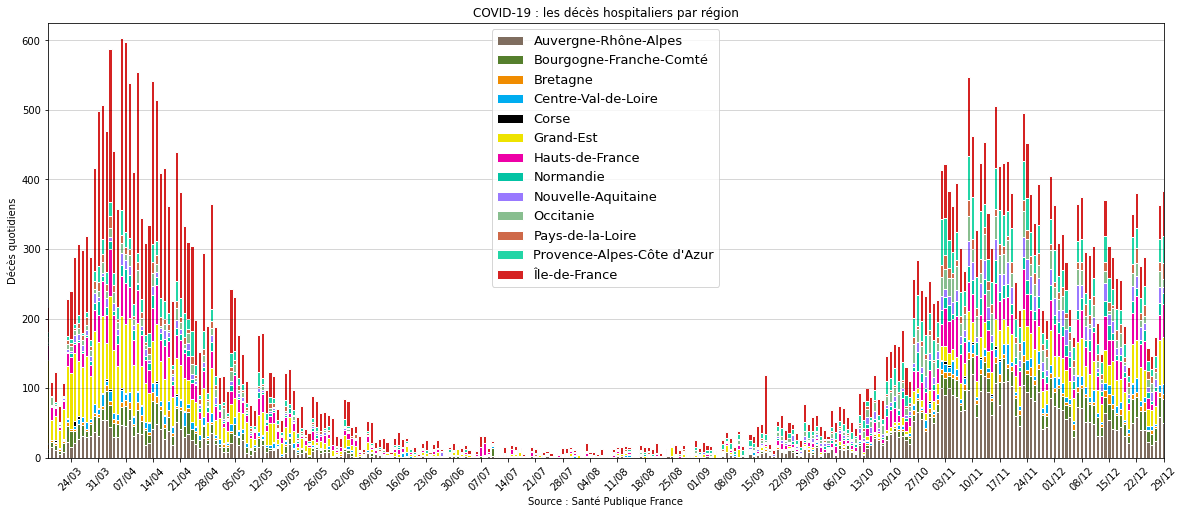

In [27]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens", title="COVID-19 : les décès hospitaliers par région")
ax.set_xlim(min(DF_tregions["jour"]), max(DF_tregions["jour"]))
ax.set_ylim(0, max(DF_deces["dcq"])+20)
date_form = DateFormatter("%d/%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_tick_params(rotation=45)
plt.bar(DF_tregions["jour"], DF_tregions["Auvergne-Rhône-Alpes"], color='#7f6d5f', edgecolor='white', label="Auvergne-Rhône-Alpes")
plt.bar(DF_tregions["jour"], DF_tregions["Bourgogne-Franche-Comté"], bottom=DF_tregions["Auvergne-Rhône-Alpes"], color='#557f2d', edgecolor='white', label="Bourgogne-Franche-Comté")
plt.bar(DF_tregions["jour"], DF_tregions["Bretagne"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"], color='#f08c00', edgecolor='white', label="Bretagne")
plt.bar(DF_tregions["jour"], DF_tregions["Centre-Val-de-Loire"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"], color='#00adf0', edgecolor='white', label="Centre-Val-de-Loire")
plt.bar(DF_tregions["jour"], DF_tregions["Corse"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"], color='#000', edgecolor='white', label="Corse")
plt.bar(DF_tregions["jour"], DF_tregions["Grand-Est"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"], color='#eee300', edgecolor='white', label="Grand-Est")
plt.bar(DF_tregions["jour"], DF_tregions["Hauts-de-France"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"], color='#ee00a7', edgecolor='white', label="Hauts-de-France")
plt.bar(DF_tregions["jour"], DF_tregions["Normandie"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"]+DF_tregions["Hauts-de-France"], color='#03c3a4', edgecolor='white', label="Normandie")
plt.bar(DF_tregions["jour"], DF_tregions["Nouvelle-Aquitaine"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"]+DF_tregions["Hauts-de-France"]+DF_tregions["Normandie"], color='#9979ff', edgecolor='white', label="Nouvelle-Aquitaine")
plt.bar(DF_tregions["jour"], DF_tregions["Occitanie"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"]+DF_tregions["Hauts-de-France"]+DF_tregions["Normandie"]+DF_tregions["Nouvelle-Aquitaine"], color='#88be8f', edgecolor='white', label="Occitanie")
plt.bar(DF_tregions["jour"], DF_tregions["Pays-de-la-Loire"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"]+DF_tregions["Hauts-de-France"]+DF_tregions["Normandie"]+DF_tregions["Nouvelle-Aquitaine"]+DF_tregions["Occitanie"], color='#ce6949', edgecolor='white', label="Pays-de-la-Loire")
plt.bar(DF_tregions["jour"], DF_tregions["Provence-Alpes-Côte d'Azur"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"]+DF_tregions["Hauts-de-France"]+DF_tregions["Normandie"]+DF_tregions["Nouvelle-Aquitaine"]+DF_tregions["Occitanie"]+DF_tregions["Pays-de-la-Loire"], color='#23d5a6', edgecolor='white', label="Provence-Alpes-Côte d'Azur")
plt.bar(DF_tregions["jour"], DF_tregions["Île-de-France"], bottom=DF_tregions["Auvergne-Rhône-Alpes"]+DF_tregions["Bourgogne-Franche-Comté"]+DF_tregions["Bretagne"]+DF_tregions["Centre-Val-de-Loire"]+DF_tregions["Corse"]+DF_tregions["Grand-Est"]+DF_tregions["Hauts-de-France"]+DF_tregions["Normandie"]+DF_tregions["Nouvelle-Aquitaine"]+DF_tregions["Occitanie"]+DF_tregions["Pays-de-la-Loire"]+DF_tregions["Provence-Alpes-Côte d'Azur"], color='#d52323', edgecolor='white', label="Île-de-France")
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.legend(loc='upper center', fontsize=13)
plt.show()

Quelques remarques :

* c'est effectivement chargé... On va plutôt partir **sur cinq régions**
* **les couleurs sont moches**, mais on va y remédier, par exemple en piochant la palette d'un Chagall [sur ce très bon site](http://colorlisa.com/)
* en toute rigueur, on a **un bon gros code de porc** sur le paramétrage des différentes barres. C'est notamment le cas **de l'option "bottom"** entre la deuxième et l'avant-dernière barre, qui regroupe l'addition des barres précédentes... Gros risque d'erreur pour ce coup
* la solution, peut-être pas la plus optimale mais assez élégante, consiste à créer une variable d'incrémentation des différentes régions **dans une boucle for**, comme ceci

In [28]:
addition_serie = liste_regions[0]
for region in liste_regions[1:]:
    # trucs à faire
    addition_serie+=region

**EDIT :** Il faut éviter d'utilisation une simple assignation de la série qu'on va incrémenter, car l'originale va être sinon incrémentée en parallèle. On utilisera donc **la fonction de pandas [copy()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html)** pour sceller cette dernière et éviter ce désagrément.

C'est parti pour le paramétrage de trois nouvelles variables : 

* une liste réduite de régions
* un dictionnaire de couleurs correspondant à chacun d'entre elles
* une DF associée

In [29]:
regions_reduites = ["Île-de-France","Grand-Est", "Auvergne-Rhône-Alpes", "Provence-Alpes-Côte d'Azur","Hauts-de-France"]

couleurs_regions = {"Île-de-France" : "#C65840", 
            "Grand-Est" : "#F4CE4B", 
            "Auvergne-Rhône-Alpes" : "#62496F", 
            "Provence-Alpes-Côte d'Azur" : "#69B7CE",
            "Hauts-de-France" : "#3F6F76"}

DF_regions_reduites = dc_region(DF,regions_reduites)

DF_regions_reduites.head()

,jour,Auvergne-Rhône-Alpes,Grand-Est,Hauts-de-France,Provence-Alpes-Côte d'Azur,Île-de-France
0,2020-03-18,7,120,21,7,36
1,2020-03-19,15,28,19,2,20
2,2020-03-20,11,35,11,2,43
3,2020-03-21,5,26,5,2,23
4,2020-03-22,9,43,11,1,18


C'est parti pour la viz, avec la boucle qui va bien :

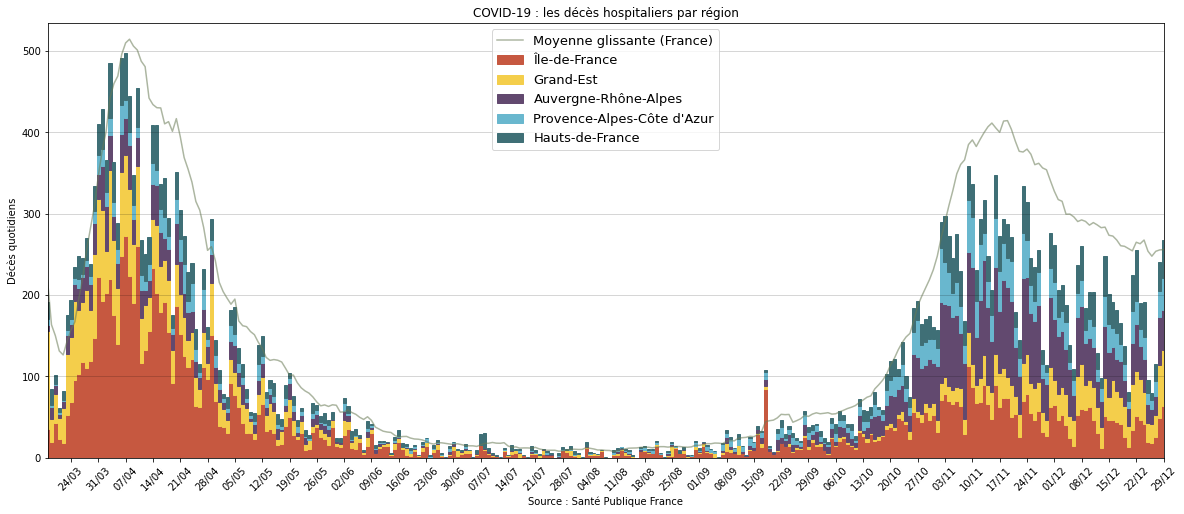

In [30]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens", title="COVID-19 : les décès hospitaliers par région")
ax.set_xlim(min(DF_regions_reduites["jour"]), max(DF_regions_reduites["jour"]))
ax.set_ylim(0, max(DF_deces["dcm"])+20)
date_form = DateFormatter("%d/%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_tick_params(rotation=45)
plt.bar(DF_regions_reduites["jour"], DF_regions_reduites[regions_reduites[0]], color=couleurs_regions[regions_reduites[0]], edgecolor=couleurs_regions[regions_reduites[0]], label=regions_reduites[0])
cascade_regions=DF_regions_reduites[regions_reduites[0]].copy()
for region in regions_reduites[1:]:
    plt.bar(DF_regions_reduites["jour"], DF_regions_reduites[region], bottom=cascade_regions, color=couleurs_regions[region], edgecolor=couleurs_regions[region], label=region)
    cascade_regions+=DF_regions_reduites[region]
ax.plot(DF_deces["jour"],DF_deces["dcm"], color="#697A55", alpha =.55, label = "Moyenne glissante (France)")
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
ax.legend(loc='upper center', fontsize=13)
plt.show()

C'est plutôt pas mal, mais en comparant les deux vagues, on distingue un défaut des barres empilées : **tout semble reposer sur la première d'entre elles**.

Pour la première vague cela fonctionne car l'Île-de-France et le Grand-Est sont les principales régions touchées, mais les choses sont un peu moins évidentes à l'automne...

On va parer à cela en :

* créant **deux DataFrames**
* une qui regroupe **toutes les valeurs avant une certaine date** (on a arbitrairement choisi le 21 septembre 2020), et l'autre celles après
* deux listes, qui vont être **un classement** (au doigt mouillée) **des régions touchées**
* en recyclant comme des sagouins le code précédent pour visualiser ces DF **qui vont se compléter comme un puzzle**

C'est parti ? C'est parti !

In [31]:
classement_v1 = ["Île-de-France","Grand-Est",  "Hauts-de-France", "Auvergne-Rhône-Alpes", "Provence-Alpes-Côte d'Azur"]
classement_v2 = ["Auvergne-Rhône-Alpes", "Île-de-France", "Hauts-de-France", "Provence-Alpes-Côte d'Azur", "Grand-Est"]

condi_v1 = DF_regions_reduites["jour"]<"2020-09-21"
condi_v2 = DF_regions_reduites["jour"]>="2020-09-21"

DF_v1 = DF_regions_reduites[condi_v1]
DF_v2 = DF_regions_reduites[condi_v2]

Petit détour statistique, en calculant le total des morts pour chaque région et chaque vague considérée :

In [32]:
print("Lors de la première vague :")
for region in classement_v1:
    print(region," : ", DF_v1[region].sum())

print("Lors de la seconde vague :")
for region in classement_v2:
    print(region," : ", DF_v2[region].sum())

Lors de la première vague :
Île-de-France  :  7951
Grand-Est  :  3719
Hauts-de-France  :  1972
Auvergne-Rhône-Alpes  :  1838
Provence-Alpes-Côte d'Azur  :  1075
Lors de la seconde vague :
Auvergne-Rhône-Alpes  :  4792
Île-de-France  :  4121
Hauts-de-France  :  2438
Provence-Alpes-Côte d'Azur  :  2426
Grand-Est  :  2205


En première vague, deux locomotives qui tirent les chiffres. En seconde, c'est beaucoup plus mêlé. Dans un cas comme dans l'autre, les régions sont bien triées dans l'ordre décroissant.

Et maintenant, l'heure de vérité :

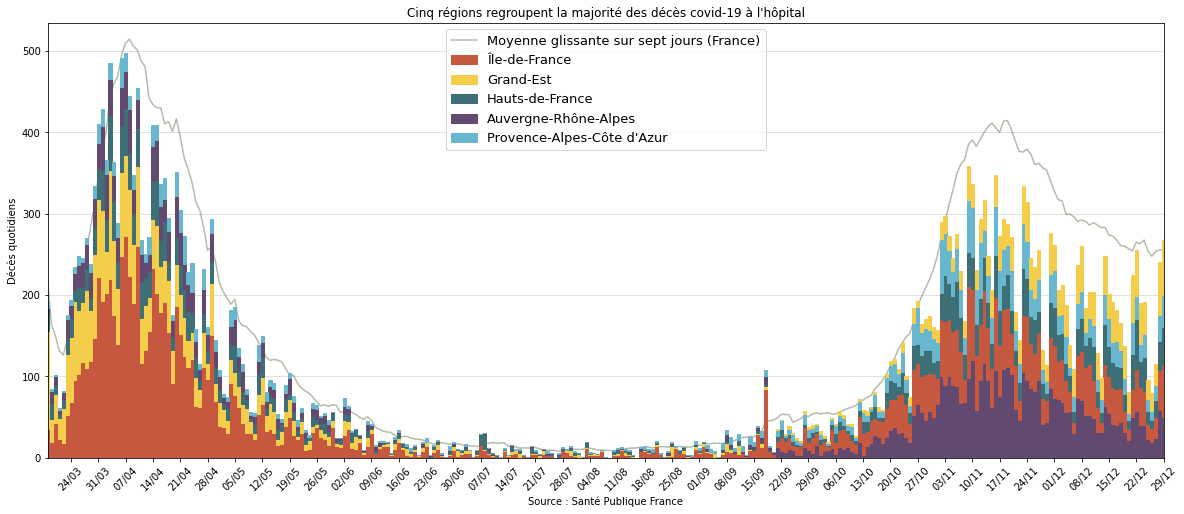

In [33]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.set(xlabel="Source : Santé Publique France", ylabel="Décès quotidiens", title="Cinq régions regroupent la majorité des décès covid-19 à l'hôpital")
ax.set_xlim(min(DF_tregions["jour"]), max(DF_tregions["jour"]))
ax.set_ylim(0, max(DF_deces["dcm"])+20)
date_form = DateFormatter("%d/%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_tick_params(rotation=45)
plt.bar(DF_v1["jour"], DF_v1[classement_v1[0]], color=couleurs_regions[classement_v1[0]], edgecolor=couleurs_regions[classement_v1[0]], label=classement_v1[0])
cascade_regions_v1=DF_v1[classement_v1[0]].copy()
for region in classement_v1[1:]:
    plt.bar(DF_v1["jour"], DF_v1[region], bottom=cascade_regions_v1, color=couleurs_regions[region], edgecolor=couleurs_regions[region], label=region)
    cascade_regions_v1+=DF_v1[region]
plt.bar(DF_v2["jour"], DF_v2[classement_v2[0]], color=couleurs_regions[classement_v2[0]], edgecolor=couleurs_regions[classement_v2[0]])
cascade_regions_v2=DF_v2[classement_v2[0]].copy()
for region in classement_v2[1:]:
    plt.bar(DF_v2["jour"], DF_v2[region], bottom=cascade_regions_v2, color=couleurs_regions[region], edgecolor=couleurs_regions[region])
    cascade_regions_v2+=DF_v2[region]
ax.plot(DF_deces["jour"],DF_deces["dcm"], color="#697A55", alpha =.5, label = "Moyenne glissante sur sept jours (France)", zorder=0)
# la ligne suivante sert notamment à passer les repères de centaines à l'arrière-plan (tout se passe grâce à l'attribut zorder)
ax.set_axisbelow(True)
ax.grid(color='#000', alpha=.15, which='major', axis='y', linestyle='solid', zorder=0)
ax.legend(loc='upper center', fontsize=13)
plt.savefig('deux_vagues_cinq_regions.png', dpi=200)
plt.show()

Plutôt joli, et prêt à être publié !